As it is (without anything downloaded and always with 1 epoch when needed), the running time of the whole notebook is (approximately) <span style="background-color: lightblue"> 2 minutes</span>.

<span style="background-color: yellow"> </span>

##### Libraries

In [1]:
########################## UTILITY AND SYSTEM ##########################

import os                       # filesystem operations
import csv                      # reading/writing CSV files
import json                     # JSON parsing and serialization
import math                     # basic math functions
import random                   # random number generation
import time                     # time-related functions
import tempfile                 # temporary file management
import tarfile                  # tar archive handling
import io                       # input/output streams
import pickle                   # object serialization
import importlib                # dynamic import of modules
import multiprocessing          # parallel process management
import pkg_resources            # package and dependency management
from copy import deepcopy       # deep copy of objects
from pathlib import Path        # filesystem paths handling (cross-platform)

########################## DOWNLOAD ##########################

import requests                 # HTTP requests library
import wget                     # file downloads from URLs
from urllib.request import urlopen  # open URLs (alternative to requests)

########################## VISUALIZATION ##########################

import matplotlib.pyplot as plt # basic plotting library
import plotly.graph_objs as go  # interactive plotting
from tqdm.notebook import tqdm  # progress bars for loops in notebooks
from pprint import pprint       # formatted pretty-printing of objects

########################## DATAFRAME ##########################

import numpy as np              # numerical arrays and operations
import pandas as pd             # dataframes and data manipulation
from sklearn.manifold import TSNE

########################## TEXT PROCESSING ##########################

import re                      # regular expressions
import string                  # string constants and operations
from itertools import chain, islice  # advanced iteration and chaining

########################## TOKENIZATION ##########################

from collections import Counter, OrderedDict  # frequency counts and ordered dictionaries
import nltk                                   # natural language processing toolkit
from nltk.tokenize import word_tokenize       # word tokenization
import spacy                                  # advanced NLP (tokenization, parsing)
from torchtext.data.utils import get_tokenizer       # torchtext tokenizers
from torchtext.data.functional import to_map_style_dataset

from torchtext.vocab import build_vocab_from_iterator # build vocabulary from iterator

########################## DATASET AND DATALOADER ##########################

from torch.utils.data import Dataset, DataLoader, random_split   # datasets and data loading utilities
from torch.nn.utils.rnn import pad_sequence                      # padding variable-length sequences
from datasets import load_dataset, DatasetDict                   # HuggingFace datasets loading
from torchtext.datasets import AG_NEWS                           # torchtext built-in datasets

########################## PYTORCH AND DEEP LEARNING ##########################

import torch                             # PyTorch main library
from torch import nn, Tensor             # neural network modules and tensors
from torch.nn import CrossEntropyLoss    # common loss function for classification
from torchsummary import summary

########################## WORD EMBEDDING ##########################

from torchtext.vocab import GloVe        # pretrained GloVe embeddings
# from gensim.models import Word2Vec     # word2vec embeddings from corpus (commented out)

########################## HUGGING FACE ##########################

import transformers                      # transformers library core
from transformers import (
    GPT2Tokenizer, GPT2LMHeadModel,     # GPT-2 tokenizer and model
    BertTokenizer, BertTokenizerFast, BertConfig, BertForMaskedLM,  # BERT components
    XLNetTokenizer,                     # XLNet tokenizer
    DistilBertForSequenceClassification, DistilBertTokenizer, AutoModelForSequenceClassification,
    pipeline,                          # easy pipelines for inference
    AutoTokenizer,                    # auto tokenizer loader
    AutoModelForCausalLM, GPT2ForSequenceClassification,
    DataCollatorForLanguageModeling, TrainingArguments, Trainer,  # training utilities
    set_seed, GenerationConfig,
    BertModel                        # BERT base model
)
from datasets import DatasetDict         # HuggingFace dataset dictionaries

######################### TRL & PEFT (TRAINING & PARAMETER EFFICIENT FINE-TUNING) ##########################

# from trl import (
#     SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM,
#     DPOConfig, DPOTrainer,
#     RewardTrainer, RewardConfig
# )
from peft import get_peft_model, LoraConfig, TaskType
from torchmetrics import Accuracy        # metrics for evaluation

########################## RAG ##########################

from transformers import (
    DPRQuestionEncoder, DPRQuestionEncoderTokenizer,
    DPRContextEncoder, DPRContextEncoderTokenizer
)
import faiss                              # similarity search library

########################## EVALUATION ##########################

import evaluate



/var/folders/35/gw8dmgsd6m11bg8nhrgpd3vr0000gn/T/ipykernel_19672/61174236.py:15: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources            # package and dependency management
/opt/miniconda3/envs/Trans_env/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/miniconda3/envs/Trans_env/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/miniconda3/envs/Trans_env/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.regi

In [2]:
def accelerator(where = "mps"):
    if where == "mps":
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        print("Which device we are on: {}".format(device))
        return device
    if where == "cuda":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Which device we are on: {}".format(device))
        return device
    if where == "cpu":
        device = torch.device("cpu")
        print("Which device we are on: {}".format(device))
        return device

device = accelerator("cpu")

Which device we are on: cpu


# 1) Tokenization

<center>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/images/Tokenization%20lab%20Diagram%202.png" width="50%" alt="Image Description">
</center>

| Library        | Tokenizer Type           | Model Specific | Pretrained | Subword Aware | Notes                                                                 |
|----------------|---------------------------|----------------|------------|----------------|-----------------------------------------------------------------------|
| spaCy          | Rule-based NLP tokenizer | No             | No         | No             | Accurate sentence/word tokenizer with POS, NER, etc.                 |
| NLTK           | Rule/Regex-based         | No             | No         | No             | Simple, customizable tokenizers (e.g., `word_tokenize`, `RegexpTokenizer`) |
| Hugging Face   | Model-specific tokenizer | Yes            | Yes        | Yes            | Designed to match exact input format expected by models like BERT    |
| TorchText      | Basic/Custom tokenizer   | No             | No         | No             | Useful for prototyping or simple tasks; supports basic English       |


| Input Text      | spaCy Tokens        | NLTK Tokens         | TorchText (`basic_english`) | BERT (`bert-base-uncased`)        |
|------------------|---------------------|----------------------|------------------------------|------------------------------------|
| playing          | ['playing']         | ['playing']          | ['playing']                  | ['play', '##ing']                 |
| New York City    | ['New', 'York', 'City'] | ['New', 'York', 'City'] | ['new', 'york', 'city']     | ['new', 'york', 'city']           |
| can't            | ['ca', "n't"]       | ["ca", "n't"]        | ['ca', "n't"]                | ['can', "'t"]                     |
| unbelievable     | ['unbelievable']    | ['unbelievable']     | ['unbelievable']             | ['un', '##bel', '##ievable']      |
| e-mail addresses | ['e', '-', 'mail', 'addresses'] | ['e-mail', 'addresses'] | ['e', 'mail', 'addresses'] | ['e', '-', 'mail', 'addresses']  |


```
tokenizer = get_tokenizer('basic_english')
tokenized_dataset = map(lambda x: tokenizer(x[1]), dataset)  # dataset[i][1] is the text
vocab = build_vocab_from_iterator(tokenized_dataset, specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"]) 
```

and 
```
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(dataset), specials=["<unk>"])
```
are equivalent. If we have the dataset already in the memory (es. dataset = [(1,"Introduction to NLP"),(2,"Basics of PyTorch")] ) we can use both, but if we are extracting a dataset from torchtext for example, **we must use yeld_tokens**, because the dataset itself is an iterator and we can not obtain the sentences as a list.


def yield_tokens(data_iter): #this build an iterator
    for index,text in data_iter:
        yield tokenizer(text)

## Word-based (spacy, nltk)
Preserves semantic meaning, increases overall vocabulary; it assigns different IDs to 'unicorn' and 'unicorns'

Import spacy models if necessary:

In [3]:
# import subprocess

# DO_INSTALL = 0

# if DO_INSTALL:
#     subprocess.check_call([
#         "python", "-m", "spacy", "download", "de_core_news_sm"
#     ])

In [4]:
text = "Unicorns are real. I saw a unicorn yesterday. I couldn't see it today"

nlp = spacy.load('en_core_web_sm')
doc = nlp(text)
token_list = [token.text for token in doc]
print(f"Tokens (spacy): {token_list}")
print(doc[0].text, doc[0].pos_, doc[0].dep_) #details of a token

nltk.download("punkt_tab")
token_list = word_tokenize(text)
print(f"Tokens (nltk ): {token_list}")

Tokens (spacy): ['Unicorns', 'are', 'real', '.', 'I', 'saw', 'a', 'unicorn', 'yesterday', '.', 'I', 'could', "n't", 'see', 'it', 'today']
Unicorns NOUN nsubj
Tokens (nltk ): ['Unicorns', 'are', 'real', '.', 'I', 'saw', 'a', 'unicorn', 'yesterday', '.', 'I', 'could', "n't", 'see', 'it', 'today']


[nltk_data] Downloading package punkt_tab to /Users/alex/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Character-based
Small vocabulary but without semantic meaning.

## Subword-based (WordPiece, Unigram, SentencePiece),  <span style="background-color: yellow"> HuggingFace tokenizers</span>
Frequently used words stay unsplit, while breaking down infrequent words. 'Unicorns' becomes 'unicorn' and 's'.


The ## means that they **are not** new words; the _ means that they **are** new words.

In [5]:
text = "Unicorns are real. I saw a unicorn yesterday. I couldn't see it today"

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased") # the WordPiece tokenizer is implemented in BertTokenizer
token_list = tokenizer.tokenize(text)
print(f"Tokens (bert): {token_list}")

tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased") # Unigram and SentencePiece 
token_list = tokenizer.tokenize(text)
print(f"Tokens (xlnet): {token_list}")


/opt/miniconda3/envs/Trans_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokens (bert): ['unicorn', '##s', 'are', 'real', '.', 'i', 'saw', 'a', 'unicorn', 'yesterday', '.', 'i', 'couldn', "'", 't', 'see', 'it', 'today']
Tokens (xlnet): ['▁Uni', 'corn', 's', '▁are', '▁real', '.', '▁I', '▁saw', '▁a', '▁', 'uni', 'corn', '▁yesterday', '.', '▁I', '▁couldn', "'", 't', '▁see', '▁it', '▁today']


## Using PyTorch (Words and sub-words), <span style="background-color: yellow">torchtext tokenizer </span>

In PyTorch, especially with the torchtext library, the tokenizer breaks down text from a data set into individual words or subwords, facilitating their conversion into numerical format. After tokenization, the vocab (vocabulary) maps these tokens to unique integers, allowing them to be fed into neural networks. This process is vital because deep learning models operate on numerical data and cannot process raw text directly. Thus, tokenization and vocabulary mapping serve as a bridge between human-readable text and machine-operable numerical data.

In [6]:
dataset = [ #it is an iterable, like a dataloader (think to the future application in DL)
    (1,"Introduction to NLP"), #the first entry is a sentiment label
    (2,"Basics of PyTorch"),
    (1,"NLP Techniques for Text Classification"),
    (3,"Named Entity Recognition with PyTorch")]

tokenizer = get_tokenizer('basic_english') # TorchText tokenizer
token_list = tokenizer(dataset[0][1])
print(f"Tokens (PyTorch): {token_list}")

def yield_tokens(data_iter): #this build an iterator
    for sentiment, text in data_iter:
        yield tokenizer(text)

my_iterator = yield_tokens(dataset) 
print(next(my_iterator))


Tokens (PyTorch): ['introduction', 'to', 'nlp']
['introduction', 'to', 'nlp']


Then we build a vocabulary:

In [7]:
vocab = build_vocab_from_iterator(yield_tokens(dataset), specials = ['<unk>']) #assigns numbers to token, and '<unk>' to words out of vocabulary
vocab.set_default_index(vocab['<unk>'])

print('Number of words in the vocabulary:',len(vocab), '\n')
vocab.get_itos() #**index_to_string** this is a list of the words in the vocabulary, already sorted by indexing (see the last two lines here)
print('Vocabulary:',vocab.get_stoi(),'\n') #this is a dictionary {'word in vocabulary': integer ID}

print(vocab.get_stoi()['with'])
print(vocab.get_itos()[14])

Number of words in the vocabulary: 15 

Vocabulary: {'with': 14, 'to': 13, 'of': 9, 'nlp': 1, 'classification': 4, 'named': 8, 'for': 6, 'text': 12, 'entity': 5, 'techniques': 11, '<unk>': 0, 'basics': 3, 'recognition': 10, 'pytorch': 2, 'introduction': 7} 

14
with


In [8]:
my_iterator = yield_tokens(dataset) 

def get_tokenized_sentences_and_IDs(iterator, vocab):
    for tokenized_sentence in iterator:
        token_indices = [vocab[token] for token in tokenized_sentence]
        print("Tokenized Sentence:", tokenized_sentence)
        print("Token Indices:", token_indices)
        print()  # riga vuota per separare

get_tokenized_sentences_and_IDs(my_iterator,vocab)

Tokenized Sentence: ['introduction', 'to', 'nlp']
Token Indices: [7, 13, 1]

Tokenized Sentence: ['basics', 'of', 'pytorch']
Token Indices: [3, 9, 2]

Tokenized Sentence: ['nlp', 'techniques', 'for', 'text', 'classification']
Token Indices: [1, 11, 6, 12, 4]

Tokenized Sentence: ['named', 'entity', 'recognition', 'with', 'pytorch']
Token Indices: [8, 5, 10, 14, 2]



In [9]:
text = """
Going through the world of tokenization has been like walking through a huge maze made of words, symbols, and meanings. Each turn shows a bit more about the cool ways computers learn to understand our language. And while I'm still finding my way through it, the journey’s been enlightening and, honestly, a bunch of fun.
Eager to see where this learning path takes me next!"
"""

# Counting and displaying tokens and their frequency

def show_frequencies(tokens, method_name):
    print(f"{method_name} Token Frequencies: {dict(Counter(tokens))}\n")



# 2) Dataset and Dataloader

## General

In [10]:
sentences = [
    "If you want to know what a man's like, take a good look at how he treats his inferiors, not his equals.",
    "Fame's a fickle friend, Harry.",
    "It is our choices, Harry, that show what we truly are, far more than our abilities.",
    "Soon we must all face the choice between what is right and what is easy.",
    "Youth can not know how age thinks and feels. But old men are guilty if they forget what it was to be young.",
    "You are awesome!"
]

class CustomDataset(Dataset):
    def __init__(self, sentences, tokenizer = None): #this are the arguments passed when initialize the class
        self.sentences = sentences
        self.tokenizer = tokenizer

    def __len__(self): #standard function which is added to the Dataset class
        return len(self.sentences)

    def __getitem__(self, idx): #standard function which is added to the Dataset class
        return self.sentences[idx]
    
    def tokenized(self, idx): #non-standard function which can be added to the Dataset class
        return self.tokenizer(self.sentences[idx])

# Create an instance of your custom dataset
custom_dataset = CustomDataset(sentences = sentences, tokenizer = get_tokenizer('basic_english') )
len(custom_dataset) ==  custom_dataset.__len__() #number of sentences, method __len__
print(len(custom_dataset))
# custom_dataset[i] == custom_dataset.__getitem__(i) #is the i-th sentence, method __getitem
print(custom_dataset[2])
print(custom_dataset.tokenized(idx = 2))



dataloader = DataLoader(dataset = custom_dataset, batch_size = 2, shuffle = True)
# len(dataloader) # number of batches, of dimension 'batch_size'

# Iterate through the DataLoader
# for batch in dataloader:
#     print(batch)

6
It is our choices, Harry, that show what we truly are, far more than our abilities.
['it', 'is', 'our', 'choices', ',', 'harry', ',', 'that', 'show', 'what', 'we', 'truly', 'are', ',', 'far', 'more', 'than', 'our', 'abilities', '.']


## For NLP purposes

COLLATE FUNCTION: <span style="background-color: yellow"> For a NLP task, we initialize the class by passing the sentences, a tokenizer, and a vocabulary. Problem is that a dataloader expects all data to have the same lenght, so we have to add padding manually, otherwise we eill encounter an error. </span>

The `pad_sequence`function adds padding, but it is not specified the maximum lenght of the padding. Instead, it computes the lenght of the longest sentence, and add padding to the other sequences to reach this number.

### Modifying the dataset (not good)

This 'modify' the dataset in the sense that we have changed the `__getitem__` function to give indices:

In [11]:
sentences = [
    "If you want to know what a man's like, take a good look at how he treats his inferiors, not his equals.",
    "Fame's a fickle friend, Harry.",
    "It is our choices, Harry, that show what we truly are, far more than our abilities.",
    "Soon we must all face the choice between what is right and what is easy.",
    "Youth can not know how age thinks and feels. But old men are guilty if they forget what it was to be young.",
    "You are awesome!"
]

class CustomDataset(Dataset):
    def __init__(self, sentences, tokenizer, vocabulary):
        self.sentences = sentences
        self.tokenizer = tokenizer
        self.vocabulary = vocabulary

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.tokenizer(self.sentences[idx])
        # Convert tokens to tensor indices using vocab
        tensor_indices = [self.vocabulary[token] for token in tokens]
        return torch.tensor(tensor_indices)
    
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, sentences))

custom_dataset = CustomDataset(sentences, tokenizer, vocab)
custom_dataset[5] #IDs of the 5-th sentence

# dataloader = DataLoader(custom_dataset, batch_size= 2 , shuffle=True)
# for batch in dataloader:
#     print(batch)              #this will rise an error

def collate_fn(batch):
    padded_batch = pad_sequence(batch, batch_first = True, padding_value = 0) # padding_value numerical value of the padding
    return padded_batch

dataloader = DataLoader(dataset = custom_dataset, batch_size = 2 , shuffle = True, collate_fn = collate_fn)
for batch in dataloader:
    print(batch) #batch is [batch_size x sequence_lenght] if batch_first = True, otherwise (default) [sequence_lenght x batch_size]
    print(f'batch shape: {batch.shape}')
    for row in batch:
        for idx in row:
            words = [vocab.get_itos()[idx] for idx in row]
        print(words)
    print()

tensor([[11, 19, 63, 17, 13,  2,  3, 47,  6, 16, 45,  0, 55,  3, 41, 46, 24, 10,
         43, 61,  9, 44,  0, 14,  9, 33,  1],
        [54, 18, 50, 23, 34, 58, 30, 27,  2,  5, 52,  7,  2,  5, 32,  1,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0]])
batch shape: torch.Size([2, 27])
['if', 'you', 'want', 'to', 'know', 'what', 'a', 'man', "'", 's', 'like', ',', 'take', 'a', 'good', 'look', 'at', 'how', 'he', 'treats', 'his', 'inferiors', ',', 'not', 'his', 'equals', '.']
['soon', 'we', 'must', 'all', 'face', 'the', 'choice', 'between', 'what', 'is', 'right', 'and', 'what', 'is', 'easy', '.', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',']

tensor([[66, 29, 14, 13, 10, 22, 60,  7, 37,  1, 28, 51, 48,  4, 42, 11, 59, 39,
          2, 12, 64, 17, 26, 65,  1],
        [19,  4, 25, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0]])
batch shape: torch.Size([2, 25])
['youth', 'can', 'not', 'know', 'how', 'age', 'thinks', 'and', 'feels'

### Without modifying the dataset: best practice

We have the option to utilize the collate function for tasks such as tokenization, converting tokenized indices, and transforming the result into a tensor. It's important to note that the original data set remains untouched by these transformations. In this way we can still access the raw data as custom_dataset[i]

In [12]:
sentences = [
    "If you want to know what a man's like, take a good look at how he treats his inferiors, not his equals.",
    "Fame's a fickle friend, Harry.",
    "It is our choices, Harry, that show what we truly are, far more than our abilities.",
    "Soon we must all face the choice between what is right and what is easy.",
    "Youth can not know how age thinks and feels. But old men are guilty if they forget what it was to be young.",
    "You are awesome!"
]

class CustomDataset(Dataset): # standard CustomDataset, with std getitem
    def __init__(self, sentences):
        self.sentences = sentences

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx]

custom_dataset = CustomDataset(sentences) #still have the raw text!

`tokenizer`and `vocab`are necessary for the `my_collate_fn`:

In [13]:
tokenizer = get_tokenizer('basic_english')
# vocab = build_vocab_from_iterator(map(tokenizer, sentences)) #alternative method, less general!

def yield_tokens(data): #this build an iterator
    for sentence in data:
        yield tokenizer(sentence)

vocab = build_vocab_from_iterator(yield_tokens(sentences), specials = ['<unk>']) #assigns numbers to token, and '<unk>' to words out of vocabulary
vocab.set_default_index(vocab['<unk>'])

#---------------------------------------------------

def my_collate_fn(batch): #always a single batch
    tensor_batch = []
    for sentence in batch: # a batch is made by batch_size sentences
        tokens = tokenizer(sentence)
        tensor_batch.append(torch.tensor([vocab[token] for token in tokens])) # this is a list of lists: the list has lenght batch_size, 
                                                                              # and each sub_list has the lenght of the sentence
    padded_batch = pad_sequence(tensor_batch, batch_first = True) # with this, each batch has sentences with different lenght, but the same lenght in the batch
    return padded_batch

#---------------------------------------------------

dataloader = DataLoader(
    dataset = custom_dataset,   # Custom PyTorch Dataset containing your data
    batch_size = 2,     # Number of samples in each mini-batch
    shuffle = True,              # Shuffle the data at the beginning of each epoch
    collate_fn = my_collate_fn      # Custom collate function for processing batches
)

for batch in dataloader:
    print(f"Batch: {batch}")
    for row in batch:
        for idx in row:
            words = [vocab.get_itos()[idx] for idx in row]
        print(words)
    print(f"Batch length: {len(batch)}")
    print(f"Each (padded) sequence has lenght: {len(batch[0])}")
    print(f"Batch shape: {batch.shape}")
    print("=" * 160)

Batch: tensor([[55, 19, 51, 24, 35, 59, 31, 28,  3,  6, 53,  8,  3,  6, 33,  2,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0],
        [12, 20, 64, 18, 14,  3,  4, 48,  7, 17, 46,  1, 56,  4, 42, 47, 25, 11,
         44, 62, 10, 45,  1, 15, 10, 34,  2]])
['soon', 'we', 'must', 'all', 'face', 'the', 'choice', 'between', 'what', 'is', 'right', 'and', 'what', 'is', 'easy', '.', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']
['if', 'you', 'want', 'to', 'know', 'what', 'a', 'man', "'", 's', 'like', ',', 'take', 'a', 'good', 'look', 'at', 'how', 'he', 'treats', 'his', 'inferiors', ',', 'not', 'his', 'equals', '.']
Batch length: 2
Each (padded) sequence has lenght: 27
Batch shape: torch.Size([2, 27])
Batch: tensor([[36,  7, 17,  4, 39, 41,  1,  9,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0],
        [13,  6, 16, 32,  1,  9,  1, 58, 54,  3, 19, 63,  5,  1, 37, 50, 57, 16,
         22,  2]])
['fame', "'", 's', 'a', 'fickle'

# A) CONCEPTS: Words to features, Evaluation

## Words to features

Given a $\text{token}_i$, we have:
- $\text{OHE}_i=\text{One-hot-encoding(token}_i)$ es. 'cat' = (0,0,1,0,0), 'I' = (1,0,0,0,0) and 'like' = (0,0,0,0,1). The vectors have lenght $D$ = number of words in the vocabulary;
- $\text{Bag-of-Words} = \sum_{i} \text{OHE}_i$ es 'I like cat' = (1,0,1,0,1). Always dimension $D$;
- $\text{Embedding}_i = W_{d\times D} \cdot \text{OHE}_i$ . Vectors are in a new representation of lenght $d$, using an embedding matrix $W_{d\times D}$.
- $\text{EmbeddingBag} = \sum_{i} \text{Embedding}_i = W_{d\times D} \cdot \sum_{i} \text{OHE}_i = W_{d\times D} \cdot \text{Bag-of-Words}$. We can use the module **nn.Linear**.

For practical purposes, it is easier to do:
- construct vocab(tokenizer(text)) --> vector = [4, 6, 10, 45];
- give it to the **nn.EmbeddingBag** module, which selects the rows (4,6,10,45) of $W_{d\times D}$ (so the input to nn.EmbeddingBag will be the dimension of the vocabulary, even if the input vector has dimension $<D$!). Thus we do $\text{EmbeddingBag} = " W_{d\times D}^{(4,6,10,45)} \cdot [4, 6, 10, 45]" \equiv W_{d\times D}^{\text{column=4}}[4] + W_{d\times D}^{\text{column=6}}[6] + W_{d\times D}^{\text{column=10}}[10]+ W_{d\times D}^{\text{column=45}}[45]$

This is easier because the input vectors have smaller dimension than $D$ (4 in the example), and the bag-of-words is done implicitly by the module.

Difference between **nn.Embedding** and **nn.EmbeddingBag**:
- **nn.Embedding**: Maps each index to an embedding vector, preserving the sequence order.
Useful for models that process sequences (e.g., RNNs, Transformers).
Requires equal-length inputs, so padding is needed — typically handled in the `collate_fn`.
- **nn.EmbeddingBag**: Computes a reduction (mean, sum, or max) over a "bag" of embeddings.
Useful for tasks like text classification, where sequence order is less important.
No padding is required, but you must provide offsets to indicate where each sample starts in a concatenated list of indices

## Evaluation

1. **Perplexity**: $e^{\text{Cross-Entropy-Loss}}$ is used generically only on the training set. We use PyTorch.
2. **Precision(n) and Recall(n)**: given a reference translation 'The cat sits on the mat' and the trduction given by the model 'The big cat sitting on the rug' we count the number of unigram matched (4) and bigram matched (1), and this gives a measure of similarity. Then  $$ \text{Precision}_n = \frac{\text{Number of common } n\text{-grams}}{\text{Number of } n\text{-grams in the prediction}}\,,\quad  \text{Recall}_n = \frac{\text{Number of common } n\text{-grams}}{\text{Number of } n\text{-grams in the reference}}\,,\quad F_1 = \frac{2}{\frac{1}{P_n}+\frac{1}{R_n}}\,.$$
3. **ROUGE** (Recall-Oriented Understudy for Gisting Evaluation): ROUGE is a set of metrics commonly used for evaluating text summarization systems. It measures the overlap between the generated summary and one or more reference summaries. ROUGE calculates various metrics, such as ROUGE-N, which measures the n-gram overlap, and ROUGE-L, which measures the longest common subsequence. Higher ROUGE scores indicate better summarization quality.
4. **BLEU** (Bilingual Evaluation Understudy): BLEU is a metric primarily used for evaluating machine translation systems. It compares the generated translation with one or more reference translations and assigns a score based on the degree of overlap. BLEU measures the precision of the generated translation by counting the number of n-grams (contiguous sequences of n words) that appear in both the generated and reference translations. A higher BLEU score indicates a better translation quality.

Libraries for evaluation:

- NLTK with

    1. BLEU: nltk.translate.bleu_score
    2. METEOR: nltk.translate.meteor_score module

- PyTorch with perplexity and celoss
- Other libraries with

    1. BLEU: torchtext.data.metrics.bleu_score
    2. ROUGE: torchmetrics.text.rouge.ROUGEScore

# 2) Text Classification on AG dataset: <span style="background-color: yellow">not Generative AI</span>

AG is a text classifiation dataset with four labels: {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}:

In [14]:
from torchtext.datasets import AG_NEWS

## From scratch:

### Dataset and DataLoader

In [15]:
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}

train_iter = iter(AG_NEWS(split="train")) #load the train dataset
test_iter = iter(AG_NEWS(split="test")) #load test datasets


train_labels = [label for (label, text) in train_iter]
num_of_classes = pd.Series(train_labels).nunique() #4
train_dataset_dimension = len(train_labels) #120000

test_labels = [label for (label, text) in test_iter]
num_of_classes = pd.Series(test_labels).nunique() #4
test_dataset_dimension = len(test_labels) #7600

train_iter = iter(AG_NEWS(split="train"))  #load the dataset again to reset the iterator
example_label, example_text = next(train_iter)

ag_news_label[example_label],example_text

('Business',
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

Next we build the tokenizer, yield_tokens and the vocabulary in the standard way:

In [16]:
train_iter = AG_NEWS(split="train")
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for label, text in data_iter:
        yield tokenizer(text.lower())  # Lowercase conversion for consistency

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

vocab.get_stoi() #this is a dictionary {'word in vocabulary': integer ID}
len(vocab) #dimension of the vocabulary, which will be the dimension of the input layer of the model!

95811

The datasets are in iterable format, which is not compatible with indicization, len() and DataLoader. To solve this issue, we convert them to a map style dataset, and now we can do `train_dataset[i]` to get the i-th sentence. Moreover it is easier to get the lenght! Finally, it is compatible with the `DataLoader`

In [17]:
train_iter, test_iter = iter(AG_NEWS(split="train")), iter(AG_NEWS(split="test")) 

train_dataset = to_map_style_dataset(train_iter) #type: Dataset, compatible with DataLoader
test_dataset = to_map_style_dataset(test_iter) 

print(train_dataset[0])

print(len(train_dataset),len(test_dataset))

(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")
120000 7600


Next we divide in train-valid-test, by dividing the train in train and validation. Since we are working with PyTorch Dataset, we hace to use `random_split` instead of the analogous function of scikit-learn:

In [18]:
num_train = int(len(train_dataset) * 0.95)
split_train, split_valid = random_split(train_dataset, [num_train, len(train_dataset) - num_train])
len(split_train)+len(split_valid)==len(train_dataset)

True

In [19]:
example_label, example_text = train_dataset[0]
torch.tensor(vocab(tokenizer(example_text)))

tensor([  431,   425,     1,  1605, 14838,   113,    66,     2,   848,    13,
           27,    14,    27,    15, 50725,     3,   431,   374,    16,     9,
        67507,     6, 52258,     3,    42,  4009,   783,   325,     1])

We are ready to define the loaders, but to do it we should define the collate function before. Since we will use `nn.EmbeddingBag`, we do not add padding in the collate function, but we have to take care of the offsets:

In [20]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for label, text in batch:

        label_list.append(int(label)-1) # Convert to zero-based index

        processed_text = torch.tensor( vocab(tokenizer(text)), dtype = torch.int64) # vocab(tokenizer(text) is the list of integers corresponidng to the tokens
        text_list.append(processed_text) # This creates a list of lists, which will be concatenated with torch.cat later
        
        offsets.append(len(processed_text)) # This is a list with the lenght of each sentence

    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = torch.cat(text_list) # Concatenate all the text tensors into a single tensor, required by EmbeddingBag
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0) # A list with the position of each word beginning, required by EmbeddingBag
    
    return label_list.to(device), text_list.to(device), offsets.to(device)

BATCH_SIZE = 64

train_loader = DataLoader(split_train, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_batch)
valid_loader = DataLoader(split_valid, batch_size = BATCH_SIZE, shuffle = False, collate_fn = collate_batch)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, collate_fn = collate_batch)

label_list, text_list, offsets_list = next(iter(valid_loader))

print(f"List of concatenated labels in a batch {label_list} with lenght of BATCH_SIZE = {len(label_list)}.\n")
print(f"List of concatenated text in a batch {text_list} with non-fixed lenght {len(text_list)}.\n")
print(f"List of offsets in a batch {offsets_list} with lenght BATCH_SIZE = {len(offsets_list)}.")

List of concatenated labels in a batch tensor([3, 0, 2, 0, 2, 3, 3, 0, 0, 2, 2, 3, 0, 0, 3, 1, 1, 3, 1, 2, 1, 1, 3, 1,
        0, 3, 1, 3, 1, 1, 1, 3, 1, 1, 3, 0, 1, 0, 0, 3, 0, 1, 1, 3, 1, 0, 2, 0,
        3, 1, 0, 2, 2, 2, 1, 1, 2, 3, 1, 0, 2, 3, 0, 3]) with lenght of BATCH_SIZE = 64.

List of concatenated text in a batch tensor([ 224,  133, 1225,  ...,    2, 3756,    1]) with non-fixed lenght 2748.

List of offsets in a batch tensor([   0,   23,   61,  100,  139,  222,  250,  279,  321,  358,  391,  428,
         448,  492,  537,  609,  647,  725,  758,  800,  852,  889,  936,  973,
        1012, 1062, 1109, 1137, 1188, 1236, 1279, 1327, 1395, 1449, 1479, 1525,
        1569, 1613, 1654, 1688, 1731, 1776, 1813, 1853, 1877, 1916, 1953, 1999,
        2091, 2136, 2164, 2205, 2242, 2279, 2332, 2385, 2427, 2484, 2515, 2554,
        2591, 2631, 2679, 2712]) with lenght BATCH_SIZE = 64.


### Model

We use the EmbeddingBag model because we started from vocab(tokenizer(text)); if we use one-hot encoding, instead, we could have used a linear layer to go to the hidden dimension.

In [21]:
class TextClassificationModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim): # The output dimension is the number of classes in the classification task: 4
                                                           # The input is the vocabulary dimension
        super(TextClassificationModel, self).__init__()

        self.embedding = nn.EmbeddingBag(input_dim, hidden_dim, sparse = False)
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets): # EmbeddingBag eats a list of concatenated integers for text in a batch, and the list of offsets
        embedded = self.embedding(text, offsets)
        output = self.fc(embedded)
        return output
    
vocab_size = len(vocab)
EMBEDDING_DIM = 64 
num_of_classes = len(ag_news_label)

model = TextClassificationModel(input_dim = vocab_size, hidden_dim = EMBEDDING_DIM, output_dim = num_of_classes).to(device)

Usage example:

In [22]:
label_list, text_list, offsets_list = next(iter(train_loader))
predicted_logits = model(text_list, offsets_list) #we obtain logits because there is not the softmax
print(predicted_logits.shape) # [BATCH_SIZE, number_of_classes]
print(f"An example of the predicted logits of the first sentence {predicted_logits[0]},\nwhich corresponds to the class {predicted_logits[0].argmax()}.\n\n")

predict_classes = predicted_logits.argmax(dim = 1) # vector of dim BATCH_SIZE containing the predicted classes
print(predict_classes)
print(label_list)

torch.Size([64, 4])
An example of the predicted logits of the first sentence tensor([0.0816, 0.0834, 0.1701, 0.0922], grad_fn=<SelectBackward0>),
which corresponds to the class 2.


tensor([2, 2, 3, 1, 2, 2, 1, 2, 3, 2, 3, 1, 3, 3, 1, 2, 0, 3, 3, 3, 0, 3, 0, 1,
        3, 3, 2, 0, 0, 3, 3, 2, 3, 1, 3, 3, 2, 0, 0, 1, 3, 0, 3, 3, 2, 1, 2, 2,
        3, 2, 2, 3, 2, 3, 2, 3, 3, 2, 0, 3, 3, 2, 1, 3])
tensor([2, 2, 1, 0, 2, 2, 0, 0, 1, 1, 3, 0, 2, 1, 0, 2, 0, 3, 3, 1, 0, 2, 3, 2,
        3, 1, 0, 3, 1, 2, 0, 0, 1, 2, 0, 1, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 1, 0,
        2, 0, 1, 2, 3, 3, 2, 1, 0, 2, 3, 2, 2, 3, 2, 0])


### Accuracy

In [23]:
def evaluate(dataloader, model ):
    model.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label_list, text_list, offsets_list) in enumerate(dataloader):
            predicted_logits = model(text_list, offsets_list)

            total_acc += (predicted_logits.argmax(1) == label_list).sum().item()
            total_count += label_list.size(0) # This is better than using BATCH_SIZE, due to possible mismathces between the dimensions
       
    return total_acc / total_count

# 7 seconds
print('Accuracies without training:', evaluate(train_loader, model), evaluate(valid_loader, model), evaluate(test_loader, model))

Accuracies without training: 0.26092105263157894 0.2608333333333333 0.26289473684210524


### Training the model

In [24]:
print(f"There are a total of {len(train_loader)} batches, which can also be computed as: '(len(train_dataset) * 0.95)// BATCH_SIZE +1' .")

There are a total of 1782 batches, which can also be computed as: '(len(train_dataset) * 0.95)// BATCH_SIZE +1' .


In [25]:
LR = 0.5
EPOCHS = 1
cum_loss_list = []
acc_epoch = []
acc_old = 0

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1.0, gamma = 0.1) # after 1.0 epochs, the lerning rate will be multiplied by gamma

for epoch in range(EPOCHS):
    cum_loss = 0.0
    print(f'epoch {epoch+1}')
    model.train()
    for i, (label_list, text_list, offsets_list) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        predicted_logits = model(text_list, offsets_list)
        loss = criterion(predicted_logits, label_list) # softmax internally, thus we pass the logits
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1) #gradient clipping
        optimizer.step()
        cum_loss += loss.item()
    
    cum_loss_list.append(cum_loss/len(train_loader))
    accu_val = evaluate(valid_loader, model)
    acc_epoch.append(accu_val)

    if accu_val > acc_old:
      acc_old= accu_val
      torch.save(model.state_dict(), 'my_model.pth')

    #scheduler.step()

epoch 1


  0%|          | 0/1782 [00:00<?, ?it/s]

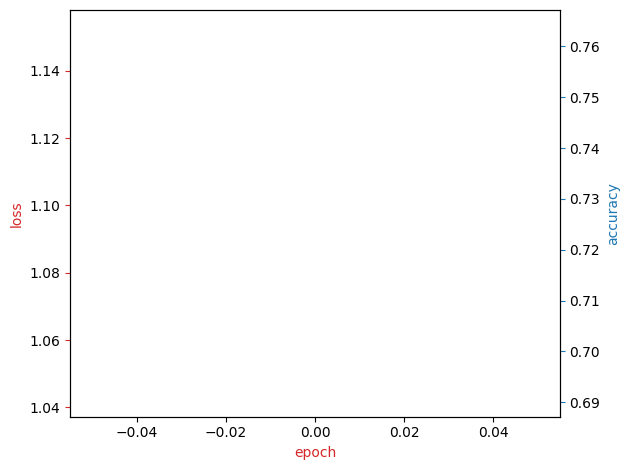

In [26]:
def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('loss', color=color)
    ax1.tick_params(axis='y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()

plot(cum_loss_list, acc_epoch)


In [27]:
def predict(text):
    with torch.no_grad():
        text = torch.tensor(vocab(tokenizer(text)))
        output = model(text, torch.tensor([0]))
        return ag_news_label[output.argmax(dim = 1).item() + 1]

real_text = [
    "International talks have made significant headway with the signing of a climate accord that commits countries to reduce emissions by 40% over the next two decades. World leaders expressed optimism at the conclusion of the summit.",
    "In a stunning upset, the underdog team won the national title, beating the favorites in a match that featured an incredible comeback and a last-minute goal that sealed their victory in front of a record crowd.",
    "Market analysts are optimistic as the tech startup's stock prices soared after the announcement of their latest product, which promises to revolutionize how we interact with smart devices.",
    "A recent study published in a leading scientific journal suggests that a new drug has shown promise in the treatment of Alzheimer's disease, outperforming current leading medications in early clinical trials.",
    "Diplomatic relations have taken a positive turn with the recent peace talks that aim to end decades of conflict. The ceasefire agreement has been welcomed by the international community.",
    "Economic indicators show a sharp rebound in manufacturing, with the automobile industry leading the charge. Analysts predict this surge will result in significant job creation over the next year.",
    "Researchers at the university's astrophysics department have discovered a potentially habitable exoplanet. The planet, which lies in a nearby star system, has conditions that could support liquid water and, possibly, life.",
    "The sports world is in shock as a legendary player announces their retirement. Over an illustrious 20-year career, the athlete has amassed numerous records and is regarded as one of the greatest to ever play the game.",
    "A multinational corporation has announced a major investment in renewable energy. The initiative includes the construction of new wind farms and solar panels that will power hundreds of thousands of homes.",
    "Climate scientists warn that the melting of the polar ice caps has been accelerating at an alarming rate, raising sea levels and threatening coastal cities worldwide with increased flooding risks."
]

predict(real_text[5])

'Business'

### Embedding analysis

In [28]:
# Get the first batch from the validation data
batch = next(iter(valid_loader))

# Extract the text and offsets from the batch
label, text, offsets = batch

# Send the data to the device (GPU if available)
text = text.to(device)
offsets = offsets.to(device)

# Get the embeddings bag output for the batch
embedded = model.embedding(text, offsets)

# Convert the embeddings tensor to a numpy array
embeddings_numpy = embedded.detach().cpu().numpy()

# Perform t-SNE on the embeddings to reduce their dimensionality to 3D.
X_embedded_3d = TSNE(n_components=3).fit_transform(embeddings_numpy)

# Create a 3D scatter plot using Plotly
trace = go.Scatter3d(
    x=X_embedded_3d[:, 0],
    y=X_embedded_3d[:, 1],
    z=X_embedded_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=label.numpy(),  # Use label information for color
        colorscale='Viridis',  # Choose a colorscale
        opacity=0.8
    )
)

layout = go.Layout(title="3D t-SNE Visualization of Embeddings",
                   scene=dict(xaxis_title='Dimension 1',
                              yaxis_title='Dimension 2',
                              zaxis_title='Dimension 3'))

fig = go.Figure(data=[trace], layout=layout)
fig.show()

## Using pretrained GloVe

### Idea

GloVe, on the other hand, is another popular algorithm for learning word embeddings. It stands for Global Vectors for Word Representation. Unlike word2vec, which is based on predicting context/target words, GloVe focuses on capturing the global word co-occurrence statistics from the entire corpus. It constructs a co-occurrence matrix that represents how often words appear together in the text. The matrix is then factorized to obtain the word embeddings. For example, if "Man" and "King" co-occure many times, their vectors will be simialr.

The GloVe model follows a fundamental approach by constructing a large word-context co-occurrence matrix that contains pairs of (word, context). Each entry in this matrix represents the frequency of a word occurring within a given context, which can be a sequence of words. The objective of the model is to utilize matrix factorization techniques to approximate this co-occurrence matrix. The process is illustrated in the following diagram:

1. Create a word-context co-occurrence matrix: The model begins by generating a matrix that captures the co-occurrence information of words and their surrounding contexts. Each element in the matrix represents how often a specific word and context pair co-occur in the training data.

2. Apply matrix factorization: Next, the GloVe model applies matrix factorization methods to approximate the word-context co-occurrence matrix. The goal is to decompose the original matrix into lower-dimensional representations that capture the semantic relationships between words and contexts.

3. Obtain word and context embeddings: By factorizing the co-occurrence matrix, the model obtains word and context embeddings. These embeddings are numerical representations that encode the semantic meaning and relationships of words and contexts.

To accomplish this, you can usually begin by initializing WF (Word-Feature matrix) and FC (Feature-Context matrix) with random weights.You will then perform a multiplication operation between these matrices to obtain WC' (an approximation of WC), and assess its similarity to WC. This process is repeated multiple times using Stochastic Gradient Descent (SGD) to minimize the error(WC'-WC).

Once the training is complete, the resulting Word-Feature matrix (WF) provides you with word embeddings or vector representations for each word(the green vector in the diagram). The dimensionality of the embedding vectors can be predetermined by setting the value of F to a specific number of dimensions, allowing for a compact representation of the word semantics.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/matrix%20fact.png" alt="Co-occurence matrix" class="bg-primary" width="600px">

The key advantage of GloVe is that it can incorporate both global statistics and local context information. This results in word embeddings that not only capture the semantic relationships between words but also preserve certain syntactic relationships.

### Download and see similarities in embedding (general, not related to text classification)

In [29]:
from torchtext.vocab import GloVe, vocab #*Glo*bal *Ve*ctors representation from Standford NLP group

glove_vectors_6B = GloVe(name='6B', dim = 50, cache = './GloVe_model/') #6B is not the number of parameters, 
                                                                        #but the number of tokens used for training
                                                                        #dim = embedding dimension


vocab = vocab(glove_vectors_6B.stoi,0, specials = ('<unk>', '<pad>'))
vocab.set_default_index(vocab['<unk>'])

word_to_index = glove_vectors_6B.stoi  # without the special tokens

embeddings_Glove6B = torch.nn.Embedding.from_pretrained(glove_vectors_6B.vectors, freeze = True)
embeddings_Glove6B.weight[vocab['team']] #dim = 50, the embedding of the word 'team'


tensor([ 0.2501, -0.0340,  0.0941,  0.3234, -0.0165, -0.6321, -1.2778,  0.3226,
        -0.1411, -0.2900, -0.7388, -1.0599, -0.6915,  0.0670,  1.4545,  0.2447,
        -0.7986, -0.8467, -0.8100, -0.1035,  0.5937,  0.4780,  0.3372, -0.4284,
        -0.3413, -1.8441,  0.3073,  0.2960, -0.4052,  0.3416,  3.4163,  0.4477,
        -0.4327,  0.1254,  0.0556, -0.5740,  0.1810,  0.0923,  0.0726, -0.4837,
        -0.7181,  0.3952, -0.1291, -0.2552,  0.4102,  0.1954, -0.1200,  0.8398,
        -0.2912,  0.0787])

This computed the similarity between two embedded words using the cosine similarity. We check the similarity between some words (it takes 13 sec):

In [30]:
def find_similar_words(target_word, embedding_dict, top_k=2):
    if target_word not in embedding_dict:
        return f"Word '{target_word}' not found in embeddings."
    
    target_vector = embedding_dict[target_word]
    similarities = {}

    for word, vector in embedding_dict.items():
        if word == target_word:
            continue
        similarity = np.dot(target_vector, vector) / (np.linalg.norm(target_vector) * np.linalg.norm(vector))
        similarities[word] = similarity

    sorted_words = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return [word for word, _ in sorted_words[:top_k]]

words = glove_vectors_6B.itos # all the tokens without the special tokens <pad> and <unk>

embedding_dict_Glove6B = {}
for word in words:
    # Get the index of the word from the vocabulary to access its embedding
    embedding_vector = embeddings_Glove6B.weight[word_to_index[word]]
    if embedding_vector is not None:
        embedding_dict_Glove6B[word] = embedding_vector

target_word = "team"
top_k=2
similar_words = find_similar_words(target_word, embedding_dict_Glove6B, top_k)

# Print the similar words
print("{} most similar words to {}:".format(top_k,target_word) ,similar_words)


2 most similar words to team: ['teams', 'football']


### Using it for text classification

In [31]:
from torchtext.vocab import GloVe, vocab #*Glo*bal *Ve*ctors representation from Standford NLP group

EMBEDDING_DIM = 300 
glove_vectors_6B = GloVe(name='6B', dim = EMBEDDING_DIM, cache = './GloVe_model/') #6B is not the number of parameters, 
                                                                        #but the number of tokens used for training
                                                                        #dim = embedding dimension

# vocab = vocab(glove_vectors_6B.stoi,0, specials = ('<unk>', '<pad>'))
# vocab.set_default_index(vocab['<unk>']) #this will bring to an error!!!

counter = Counter(glove_vectors_6B.stoi.keys())
ordered_dict = OrderedDict(counter.most_common())

# Crea vocab e aggiungi special tokens
vocab = vocab(ordered_dict)
vocab.insert_token('<unk>', 0)
vocab.insert_token('<pad>', 1)
vocab.set_default_index(vocab['<unk>'])

tokenizer = get_tokenizer("basic_english")

train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset) * 0.95)
split_train, split_valid = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
num_class = len(set([label for (label, text) in train_iter ]))

Same collate as before (with the difference of the `.lower()` in `processed_text`), with coherence with GloVe:

In [32]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for label, text in batch:

        label_list.append(int(label)-1)

        processed_text = torch.tensor(vocab(tokenizer(text.lower())), dtype=torch.int64) 
        text_list.append(processed_text)
        
        offsets.append(len(processed_text))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

BATCH_SIZE = 64

train_loader = DataLoader(split_train, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_batch)
valid_loader = DataLoader(split_valid, batch_size = BATCH_SIZE, shuffle = False, collate_fn = collate_batch)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, collate_fn = collate_batch)

Same model as before, but there is the pretrained nn:

In [33]:
class TextClassificationModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TextClassificationModel, self).__init__()

        embedding_matrix = torch.zeros(input_dim, hidden_dim)
        for token, idx in vocab.get_stoi().items(): # we use the GloVe embedding for tokens known by GloVe, otherwise random integers
            if token in glove_vectors_6B.stoi:
                embedding_matrix[idx] = glove_vectors_6B[token]
            else:
                embedding_matrix[idx] = torch.randn(hidden_dim)  

        self.embedding = nn.EmbeddingBag.from_pretrained(embedding_matrix, freeze = True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        # self.embedding.weight.data.uniform_(-initrange, initrange) #this is useless becuse of the freeze = True!
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        output = self.fc(embedded)

        return output

vocab_size = len(vocab)
# EMBEDDING_DIM = 300 # defined before 
num_of_classes = len(ag_news_label)

model = TextClassificationModel(input_dim = vocab_size, hidden_dim = EMBEDDING_DIM, output_dim = num_of_classes).to(device)

Same accuracy as before:

In [34]:
def evaluate(dataloader, model ):
    model.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

evaluate(test_loader, model)

0.31355263157894736

In [35]:
LR = 0.5
EPOCHS = 2
cum_loss_list=[]
acc_epoch=[]
acc_old=0

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1.0, gamma = 0.1) # after 1.0 epochs, the lerning rate will be multiplied by gamma

for epoch in range(EPOCHS):
    cum_loss = 0.0
    print(f'epoch {epoch+1}')
    model.train()
    for i, (label, text, offsets) in enumerate(tqdm(train_loader)):
        
        optimizer.zero_grad()
        predicted_logits = model(text, offsets)
        loss = criterion(predicted_logits, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1) #gradient clipping
        optimizer.step()
        cum_loss += loss.item()
    
    cum_loss_list.append(cum_loss/len(train_loader))
    accu_val = evaluate(valid_loader, model)
    acc_epoch.append(accu_val)

    if accu_val > acc_old:
      acc_old= accu_val
      torch.save(model.state_dict(), 'my_model.pth')


epoch 1


  0%|          | 0/1782 [00:00<?, ?it/s]

epoch 2


  0%|          | 0/1782 [00:00<?, ?it/s]

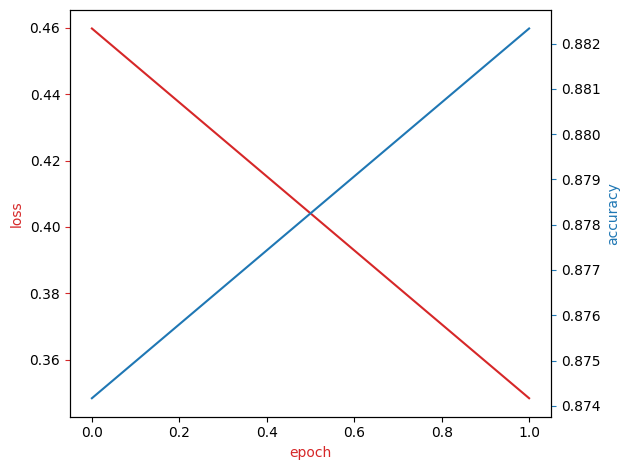

In [36]:
def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('loss', color=color)
    ax1.tick_params(axis='y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()

plot(cum_loss_list, acc_epoch)

<span style="background-color: yellow"> In the Dataset class, the methods len e getitem are not defined because they depend strictly on the type on objects we have in the databse. So it is common practice to define a CustomDataset class, with the methods len e getitem!</span>

DataLoader is an iterable but not an iterator:
1. data_iterator = iter(dataloader)
2. first_batch = next(data_iterator)